In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import scipy
import scipy.signal
from torchvision import datasets

# 2D Convolution using ajacency matrix

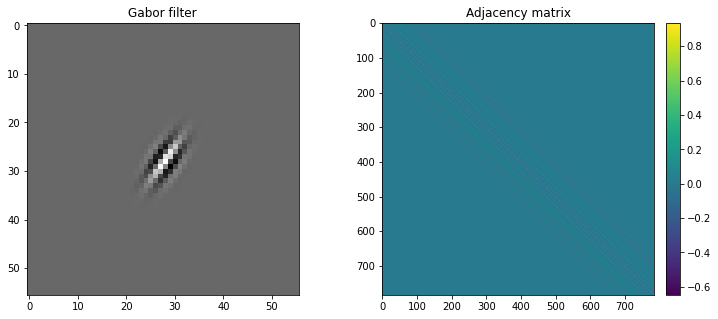

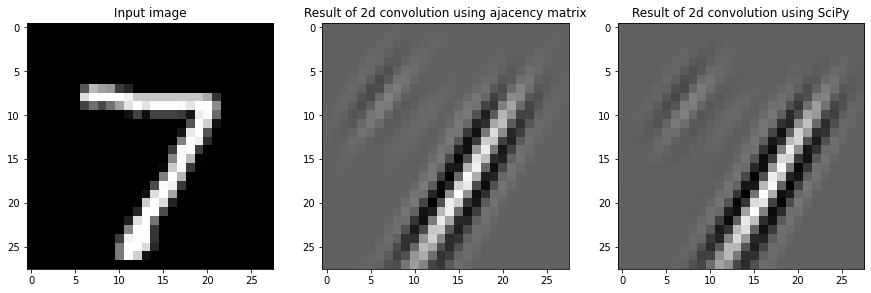

In [4]:
data = datasets.MNIST('../data', train=False, download=True)
images = (data.data.numpy() / 255.)
X = images[0].astype(np.float32)  # 28x28 MNIST image

# Create and plot the Gabor filter
N = X.shape[0]
x, y = np.meshgrid(np.arange(-float(N), N), np.arange(-float(N), N))
y = skimage.transform.rotate(y, 35)
x2 = skimage.transform.rotate(x, -35)
sigma = 0.75 * np.pi
lmbda = 1.5 * sigma
gamma = 1.3
gabor = np.exp(-(x**2 + gamma*y**2)/(2*sigma**2))*np.cos(2*np.pi*x2/lmbda)

# Create the adjacency matrix based on the Gabor filter without any zero-padding
A = np.zeros((N ** 2, N ** 2))
for i in range(N):
    for j in range(N):
        A[i*N + j, :] = gabor[N - i:N - i + N, N - j:N - j + N].flatten()
        
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Gabor filter')
plt.imshow(gabor, cmap='gray')
plt.subplot(122)
ax = plt.imshow(A)
plt.title('Adjacency matrix')
plt.colorbar(ax, fraction=0.046, pad=0.04)
plt.show()

# Perform 2d convolution as matrix multiplication
Y_adj = A.dot(X.reshape(-1, 1)).reshape(N, N)

# Plot the results and compare to the SciPy result
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Input image')
plt.imshow(X, cmap='gray')
plt.subplot(132)
plt.imshow(Y_adj, cmap='gray')
plt.title('Result of 2d convolution using ajacency matrix')
plt.subplot(133)
Y = scipy.signal.convolve2d(X, gabor, mode='same')
plt.imshow(Y, cmap='gray')
plt.title('Result of 2d convolution using SciPy')
plt.show()

In [5]:
A

array([[ 9.35450981e-01, -1.98160853e-01, -5.60563243e-01, ...,
         3.57899078e-25,  3.62199164e-27,  3.06130317e-29],
       [ 4.01920506e-01,  9.35450981e-01, -1.98160853e-01, ...,
         2.95355968e-23,  3.57899078e-25,  3.62199164e-27],
       [-5.25473645e-01,  4.01920506e-01,  9.35450981e-01, ...,
         2.03564928e-21,  2.95355968e-23,  3.57899078e-25],
       ...,
       [ 3.57899078e-25,  2.95355968e-23,  2.03564928e-21, ...,
         9.35450981e-01, -1.98160853e-01, -5.60563243e-01],
       [ 3.62199164e-27,  3.57899078e-25,  2.95355968e-23, ...,
         4.01920506e-01,  9.35450981e-01, -1.98160853e-01],
       [ 3.06130317e-29,  3.62199164e-27,  3.57899078e-25, ...,
        -5.25473645e-01,  4.01920506e-01,  9.35450981e-01]])

# 2D Convolution using circulant matrices

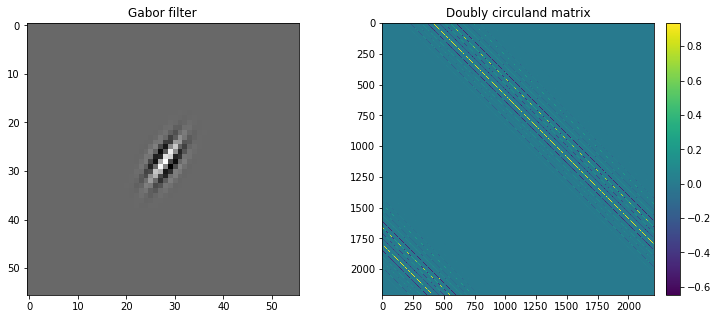

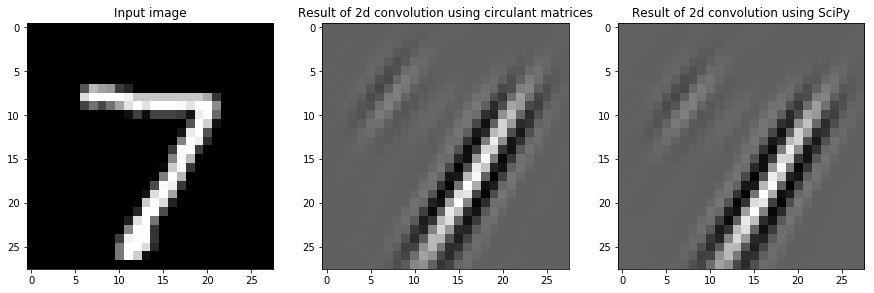

In [ ]:
filter_width = 10  # effective width of a Gabor filter

# If you set 'pad' to 0, then A will be 784x784 and can be interpreted as an adjacency matrix
pad = filter_width * 2 - 1

# Create and plot the Gabor filter
N = X.shape[0]
x, y = np.meshgrid(np.arange(-float(N), N), np.arange(-float(N), N))
y = skimage.transform.rotate(y, 35)
x2 = skimage.transform.rotate(x, -35)
sigma = 0.75 * np.pi
lmbda = 1.5 * sigma
gamma = 1.3
gabor_filt = np.exp(-(x**2 + gamma*y**2)/(2*sigma**2))*np.cos(2*np.pi*x2/lmbda)

# Create and plot doubly circuland matrix for the defined Gabor filter
gabor = gabor_filt[filter_width:X.shape[0]+filter_width, X.shape[0]-filter_width:-filter_width]
gabor = np.pad(gabor, ((pad, 0), (0, pad)), 'constant')
A = [scipy.linalg.circulant(gabor[i, :]) for i in range(gabor.shape[0])]
blocks = []
for i in range(gabor.shape[0]):
    blocks.append([])
    for j in range(gabor.shape[0]):
        blocks[-1].append(A[i - j])    
A = np.block(blocks)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Gabor filter')
plt.imshow(gabor_filt, cmap='gray')
plt.subplot(122)
ax = plt.imshow(A)
plt.title('Doubly circuland matrix')
plt.colorbar(ax, fraction=0.046, pad=0.04)
plt.show()

X_pad = np.pad(X[:, :], ((int(np.ceil(pad / 2)), pad // 2), 
                         (int(np.ceil(pad / 2)), pad // 2)), 'constant')

# Perform 2d convolution as matrix multiplication
n = int(np.sqrt(A.shape[0]))
offset = np.max((0, (pad - filter_width * 2) // 2))
Y_circulant = A.dot(X_pad.reshape(-1, 1)).reshape(n, n)

# Cut the valid part of the convolution
Y_circulant = Y_circulant[offset: offset + X.shape[0], 
                          -X.shape[1] - offset: n - offset]

# Plot the results and compare to the SciPy result
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Input image')
plt.imshow(X, cmap='gray')
plt.subplot(132)
plt.imshow(Y_circulant, cmap='gray')
plt.title('Result of 2d convolution using circulant matrices')
plt.subplot(133)
Y = scipy.signal.convolve2d(X, gabor_filt, mode='same')
plt.imshow(Y, cmap='gray')
plt.title('Result of 2d convolution using SciPy')
plt.show()